 <h1 align="center">An introduction to</h1><img src="logo.svg" width = 400em  
 style="padding-top:3em;
  margin-left:auto;
  margin-right:auto">
<div style="width:100%; text-align:center">
 <div style="width:7em;
  display:inline-block">
  <img src="csail_logo.png">
 </div>
 <div style="width:13em;
  display:inline-block">
  <h3 align="center">Kavli Code Coffee</h3>
  <h3 align="center">March 2016</h3>
  <h2 align="center">Andreas Noack</h2>
 </div>
 <div style="width:7em;
    display:inline-block">
  <img src="MIT_logo.svg">
 </div>
</div>

# Why Julia?

## The two language problem

- Old model:
 1. Prototype in R, Python, or Matlab
 2. Rewrite in C++ or Java
- New model: **Julia**?
 - As productive R, Python, and Matlab
 - As fast as C, C++, Fortran, and Java

## Source is open and readable

- If you want to know how things work - just read the source
- Large majority of standard library written in Julia

## Types and generic programming

- Rich type system
- Extensive function overloading with negligible overhead
- JIT compilation avoids unnecessary method compilation

## Metaprogramming

- Enables flexibility and specialization simultaneously

# Julia Basics

## Numbers
Julia number types correspond to their machine or library representation (in contrast to Python).

Some of these have *literals* while others can be constructed by conversion.

Promotion is implicit

In [41]:
x = 2.0  # 64 bit floating point
y = 2    # 64 bit integer (for 64 bit machines)
z = 2//1 # Rational{Int64}
æ = Float64(2);

In [42]:
x + y

4.0

In [43]:
y * z

4//1

In [44]:
y / y # promotion to floating point before division

1.0

## Arrays
Julia arrays are n-dimensional. 1 and 2 dimensional arrays have the aliases *Vector* and *Matrix*

In [45]:
rand(1:10, 3)
[1//(i + j - 1) for i = 1:4, j = 1:4] # comprehension

4x4 Array{Rational{Int64},2}:
 1//1  1//2  1//3  1//4
 1//2  1//3  1//4  1//5
 1//3  1//4  1//5  1//6
 1//4  1//5  1//6  1//7

In [46]:
A = randn(2,2)
B = randn(2,2)
chol(A'A)

2x2 UpperTriangular{Float64,Array{Float64,2}}:
 1.03945  -0.80235
 0.0       0.34936

## Functions 1


In [55]:
fibonacci(n) = n <= 2 ? 1 : fibonacci(n - 1) + fibonacci(n - 2)
# [fibonacci(i) for i = 1:10]
@code_native fibonacci(3)

	.section	__TEXT,__text,regular,pure_instructions
Filename: In[55]
Source line: 1
	pushq	%rbp
	movq	%rsp, %rbp
	pushq	%r15
	pushq	%r14
	pushq	%rbx
	pushq	%rax
	movq	%rdi, %rbx
	cmpq	$2, %rbx
	jle	L67
Source line: 1
	leaq	-1(%rbx), %rdi
	movabsq	$fibonacci, %r15
	callq	*%r15
	movq	%rax, %r14
	addq	$-2, %rbx
	movq	%rbx, %rdi
	callq	*%r15
	addq	%r14, %rax
	addq	$8, %rsp
	popq	%rbx
	popq	%r14
	popq	%r15
	popq	%rbp
	ret
L67:	movl	$1, %eax
	addq	$8, %rsp
	popq	%rbx
	popq	%r14
	popq	%r15
	popq	%rbp
	ret


## Functions 2
A naive implementation of the exponential function by its power series
$$
\exp(x) = \sum_{n=0}^\infty \frac{x^n}{n!}
$$
requires a few lines

In [52]:
function exponential(x)
    y  = zero(x)
    yn = xn = one(x)
    n  = 1
    while yn != y
        y   = yn
        xn *= x/n
        n  += 1
        yn += xn
    end 
    return y
end
@time exponential(1.0f0)

2.718282f0

0.000003 seconds (5 allocations: 176 bytes)


## Anonymous functions
Also called lambdas or closures.

Very useful, but slow in Julia 0.4. This will change in version 0.5.

In [56]:
f = t -> (1 + t)^2
mapreduce(f, +, randn(100))

220.61170319724488

## Generic functions, user defined types and immutables

- Almost no difference between user defined and built-in types
- Easy to overload functions
- Negligible overhead

In [2]:
immutable WeirdInt <: Number
    n::Int
end

In [57]:
import Base: +
(+)(a::WeirdInt, b::WeirdInt) = WeirdInt(a.n + b.n + 1)
n = WeirdInt(1)
@show n + n;

n + n = WeirdInt(3)


In [58]:
type MatrixWithMetadata{T} <: AbstractMatrix{T}
    mat::Matrix{T}
    metadata::ASCIIString
end

LoadError: LoadError: invalid redefinition of constant MatrixWithMetadata
while loading In[58], in expression starting on line 1

In [59]:
Base.size(A::MatrixWithMetadata) = size(A.mat)
Base.getindex(A::MatrixWithMetadata, i::Integer, j::Integer) =
 A.mat[i,j]
A = MatrixWithMetadata(randn(5,4), "RandomNumbers")

5x4 MatrixWithMetadata{Float64}:
  1.73001    0.948751   0.66908    0.951356
  0.515014  -0.436546  -1.84671    0.578474
 -1.91088    1.4022    -1.69334    1.04621 
 -1.25908    1.21174    0.524301   1.54277 
  0.270929   1.59862    1.1736    -0.205399

# Speed of Julia

<img src="speed.png">
- "...compiler performance on a range of common code patterns..."
- "The point...is not to compare the fastest means of computing a result"

## Example: Gibbs sampler
### Example taken http://dmbates.blogspot.com/ who tool it from https://github.com/fonnesbeck/useRshootout/blob/master/slides/UseR_2012.ipynb

The task is to create a Gibbs sampler for the unscaled density
$$
f(x,y) = x^2 \exp(-xy^2 - y^2 + 2y - 4x)
$$
using the conditional distributions
$$
 X|Y=y \sim \Gamma(3, y^2 +4) \\
 Y|X=x \sim N\left(\frac{1}{1+x}, \frac{1}{2(1+x)}\right)
 $$

In [60]:
using Distributions # I'll explain packages later

function gibbs1(n, thin)
    mat = zeros(2, n)
    x = 0
    y = 0
    for i in 1:n
        for j in 1:thin
            x = rand(Gamma(3, y * y + 4))
            y = rand(Normal(1 / (x + 1), 1 / sqrt(2 * (x + 1))))
        end
        mat[1, i] = x
        mat[2, i] = y
    end
    return mat
end

gibbs1 (generic function with 1 method)

In [61]:
@time gibbs1(20000, 200);

  0.815660 seconds (20.05 M allocations: 367.629 MB, 11.69% gc time)


In [63]:
function gibbs2(n, thin)
    mat = zeros(2, n)
    x = 0.0 # Float64
    y = 0.0 # Float64
    for i in 1:n
        for j in 1:thin
            x = rand(Gamma(3, y * y + 4))
            y = rand(Normal(1 / (x + 1), 1 / sqrt(2 * (x + 1))))
        end
        mat[1, i] = x
        mat[2, i] = y
    end
    return mat
end

gibbs2 (generic function with 1 method)

In [11]:
@time gibbs2(20000, 200);

  0.300575 seconds (9.29 k allocations: 724.797 KB)


In [12]:
@code_warntype gibbs1(20000, 200)

Variables:
  n::Int64
  thin::Int64
  mat::Array{Float64,2}
  x::ANY
  y::ANY
  #s41::Int64
  i::Int64
  #s40::Int64
  j::Int64
  ##dims#7795::Tuple{Int64,Int64}

Body:
  begin  # In[7], line 4:
      mat = (Base.fill!)((Base.Array)(Base.Float64,2,n::Int64)::Array{Float64,2},(Base.box)(Float64,(Base.sitofp)(Float64,0)))::Array{Float64,2} # In[7], line 5:
      x = 0 # In[7], line 6:
      y = 0 # In[7], line 7:
      GenSym(0) = $(Expr(:new, UnitRange{Int64}, 1, :(((top(getfield))(Base.Intrinsics,:select_value)::I)((Base.sle_int)(1,n::Int64)::Bool,n::Int64,(Base.box)(Int64,(Base.sub_int)(1,1)))::Int64)))
      #s41 = (top(getfield))(GenSym(0),:start)::Int64
      unless (Base.box)(Base.Bool,(Base.not_int)(#s41::Int64 === (Base.box)(Base.Int,(Base.add_int)((top(getfield))(GenSym(0),:stop)::Int64,1))::Bool)) goto 1
      2: 
      GenSym(57) = #s41::Int64
      GenSym(58) = (Base.box)(Base.Int,(Base.add_int)(#s41::Int64,1))
      i = GenSym(57)
      #s41 = GenSym(58) # In[7], line 8:
  

In [13]:
@code_warntype gibbs2(20000, 200)

Variables:
  n::Int64
  thin::Int64
  mat::Array{Float64,2}
  x::Float64
  y::Float64
  #s41::Int64
  i::Int64
  #s40::Int64
  j::Int64
  ##dims#7829::Tuple{Int64,Int64}
  ##I#7830::Tuple{}
  ##I#7831::Tuple{}

Body:
  begin  # In[10], line 2:
      mat = (Base.fill!)((Base.Array)(Base.Float64,2,n::Int64)::Array{Float64,2},(Base.box)(Float64,(Base.sitofp)(Float64,0)))::Array{Float64,2} # In[10], line 3:
      x = 0.0 # In[10], line 4:
      y = 0.0 # In[10], line 5:
      GenSym(0) = $(Expr(:new, UnitRange{Int64}, 1, :(((top(getfield))(Base.Intrinsics,:select_value)::I)((Base.sle_int)(1,n::Int64)::Bool,n::Int64,(Base.box)(Int64,(Base.sub_int)(1,1)))::Int64)))
      #s41 = (top(getfield))(GenSym(0),:start)::Int64
      unless (Base.box)(Base.Bool,(Base.not_int)(#s41::Int64 === (Base.box)(Base.Int,(Base.add_int)((top(getfield))(GenSym(0),:stop)::Int64,1))::Bool)) goto 1
      2: 
      GenSym(57) = #s41::Int64
      GenSym(58) = (Base.box)(Base.Int,(Base.add_int)(#s41::Int64,1))
      i 

# Packages

- Julia's package manager is based on `git`
- Most packages are registered in https://github.com/JuliaLang/METADATA.jl
- `Pkg.add("SomePackage")` to install a registered package
- `using SomePackage` to load a package

## Distributions.jl

Standardized interface for a broad range of distributions, e.g. random number generation, CDFs, PDFs, and quantiles.

In [14]:
using Distributions
X = Beta(2,0.8)
data = rand(X, 5)
@show cdf(X, 0.5)
@show quantile(X, 0.95);

cdf(X,0.5) = 0.19591115150207541
quantile(X,0.95) = 0.9885874566758995


## StatsBase.jl

Core statistics functions like autocorrelation functions and weighted statistics. It also defines common generic functions and types for statistical models.

In [15]:
import StatsBase
StatsBase.autocor(randn(10^7), 0:10)

11-element Array{Float64,1}:
  1.0        
  6.16099e-5 
  0.000419547
 -0.000557792
 -0.000543632
 -0.00032782 
  0.000402821
  0.000253025
 -0.000351486
  7.69624e-5 
  3.54813e-5 

In [16]:
@show mean([1,2,3])
@show mean([1,2,3], StatsBase.weights([2,1,1])); 

mean([1,2,3]) = 2.0
mean([1,2,3],StatsBase.weights([2,1,1])) = 1.75


## DataFrames.jl
Somewhat similar to R's `data.frame`. In contrast to `Array`, a `DataFrame` can contain heterogenous data and missing values. **Warning** be careful not to treat a `DataFrame` as a `Matrix` for performance critical computations.

In [20]:
using DataFrames
# df1 = DataFrame(x = rand(1:2, 5), y = randn(5), z = rand('a':'c', 5))
# df2 = DataFrame(id = 1:5, y1 = randn(5), y2 = randn(5))
# df3 = stack(df2, [:y1, :y2], :id)
df4 = unstack(df3, :id, :variable, :value)

,id,y1,y2
1,1,0.20901512120215168,0.20052181645076414
2,2,-0.14021894719979514,1.1513847970573856
3,3,-0.03310141658307832,0.8059239077212257
4,4,0.8223060719325033,-0.07249648771810781
5,5,1.0897506425882073,-1.1057509861469181


## Optim.jl (and JuliaOpt in general)
The `Optim` package has basic functionality for general optimization, i.e. Nelder-Mead, BFGS, and Newton's method. 

Optimization is one of Julia's major success stories. The de facto standard language for optimization at MIT and Stanford. Main reason is [JuMP.jl](https://github.com/JuliaOpt/JuMP.jl) (but I won't have time for that).

In [22]:
import Optim

rb = x -> (1.0 - x[1])^2 + 100.0 * (x[2] - x[1]^2)^2
Optim.optimize(rb, randn(2))

Results of Optimization Algorithm
 * Algorithm: Nelder-Mead
 * Starting Point: [-1.3405427551424873,-0.4587288223290833]
 * Minimum: [1.000005113689415,1.0000145527458049]
 * Value of Function at Minimum: 0.000000
 * Iterations: 62
 * Convergence: true
   * |x - x'| < NaN: false
   * |f(x) - f(x')| / |f(x)| < 1.0e-08: true
   * |g(x)| < NaN: false
   * Exceeded Maximum Number of Iterations: false
 * Objective Function Calls: 118
 * Gradient Call: 0

## GLM.jl

- Similar to R's `lm` and `glm`.
- Written by a former R Core member

In [26]:
import GLM
n = 10^6
df = DataFrame(x1 = randn(n), x2 = randn(n), x3 = randn(n))
df[:y1] = df[:x1] + df[:x2] + df[:x3] + randn(n)
df[:y2] = (df[:x1] + df[:x2] + df[:x3]) .> rand(Logistic(), n)
# GLM.lm(y1 ~ x1 + x2 + x3, df)
GLM.glm(y2 ~ x1 + x2 + x3, df, Binomial(), GLM.LogitLink())

DataFrames.DataFrameRegressionModel{GLM.GeneralizedLinearModel{GLM.GlmResp{Array{Float64,1},Distributions.Binomial,GLM.LogitLink},GLM.DensePredChol{Float64,Base.LinAlg.Cholesky{Float64,Array{Float64,2}}}},Float64}

Formula: y2 ~ 1 + x1 + x2 + x3

Coefficients:
               Estimate  Std.Error z value Pr(>|z|)
(Intercept)  0.00463781 0.00246317 1.88286   0.0597
x1             0.995836 0.00289768 343.667   <1e-99
x2             0.995712 0.00289531 343.905   <1e-99
x3             0.990787 0.00289163  342.64   <1e-99


## TimeSeries.jl

- Array like functionality for time series. 
- Provides time based indexing and time series aggregation.

In [28]:
import TimeSeries
dr = Date("2015-01-01"):Date("2015-01-31")
ts = TimeSeries.TimeArray(collect(dr), randn(length(dr), 5), ["x"*"$i" for i = 1:5])
TimeSeries.when(ts, TimeSeries.dayname, "Monday")
ts[Date("2015-01-07"):Date("2015-01-12")]

6x5 TimeSeries.TimeArray{Float64,2,Date,Array{Float64,2}} 2015-01-07 to 2015-01-12

             x1      x2      x3      x4      x5      
2015-01-07 | 0.6009  -0.6163 1.2285  0.1451  1.2331  
2015-01-08 | 0.8324  1.0325  1.1528  -1.0899 -1.2343 
2015-01-09 | -0.2766 -0.3002 0.208   -0.2047 -1.233  
2015-01-10 | 0.9969  -0.8445 0.5509  -0.3089 0.8552  
2015-01-11 | -0.601  -1.4258 -1.3563 -2.6164 0.65    
2015-01-12 | 1.1669  1.3918  0.3529  1.2607  1.1691  


## Quandl.jl

A package for time series

In [29]:
import Quandl
google = Quandl.quandl("GOOG/NASDAQ_QQQ", rows = 2000,
    format = "DataFrame")

,Date,Open,High,Low,Close,Volume
1,2008-04-28,47.25,47.62,47.13,47.24,7.1243949e7
2,2008-04-29,47.15,47.76,47.06,47.6,9.1270601e7
3,2008-04-30,47.69,48.06,47.03,47.21,1.32152671e8
4,2008-05-01,47.24,48.72,47.22,48.7,1.43596884e8
5,2008-05-02,49.19,49.19,48.34,48.77,1.24983613e8
6,2008-05-05,48.73,49.03,48.4,48.63,7.5624625e7
7,2008-05-06,48.49,49.13,48.14,48.93,1.39582514e8
8,2008-05-07,48.93,49.23,47.87,48.04,1.40008268e8
9,2008-05-08,48.24,48.7,48.06,48.4,1.28058662e8
10,2008-05-09,48.03,48.46,47.9,48.21,9.7058376e7


## JLD.jl

Julia's dialect of the data storage format HDF5

In [30]:
import JLD

JLD.save("google.jld", "google", google)

In [31]:
tmp = JLD.load("google.jld")

Dict{ByteString,Any} with 1 entry:
  "google" => 2000x6 DataFrames.DataFrame…

In [32]:
tmp["google"]

,Date,Open,High,Low,Close,Volume
1,2008-04-28,47.25,47.62,47.13,47.24,7.1243949e7
2,2008-04-29,47.15,47.76,47.06,47.6,9.1270601e7
3,2008-04-30,47.69,48.06,47.03,47.21,1.32152671e8
4,2008-05-01,47.24,48.72,47.22,48.7,1.43596884e8
5,2008-05-02,49.19,49.19,48.34,48.77,1.24983613e8
6,2008-05-05,48.73,49.03,48.4,48.63,7.5624625e7
7,2008-05-06,48.49,49.13,48.14,48.93,1.39582514e8
8,2008-05-07,48.93,49.23,47.87,48.04,1.40008268e8
9,2008-05-08,48.24,48.7,48.06,48.4,1.28058662e8
10,2008-05-09,48.03,48.46,47.9,48.21,9.7058376e7


### What about time database tools and time series econometrics?

- Database support: ODBC, MySQL, Hive, and more, see https://github.com/JuliaDB

# Plotting

- Several plotting packages and no plotting in `Base`
 - [`PyPlot.jl`](https://github.com/stevengj/PyPlot.jl), wrapper around the [Python package](http://matplotlib.org/) using the [PyPlot API](http://matplotlib.org/api/pyplot_api.html). Solid and comprehensive.
 - [`Gadfly.jl`](http://gadflyjl.org/), pure Julia. Similar to R's `ggplot2`. Less comprehensive than `PyPlot.jl`, but more modern style (Grammar of Graphics).
 - [`GLVisualize.jl`](https://github.com/JuliaGL/GLVisualize.jl), heavy weight 3D or BigData plotting. Complicated, but can handle very big data.
 - [`Bokeh.jl`](https://github.com/bokeh/Bokeh.jl) (wrapper for the [JavaScript library](http://bokeh.pydata.org/en/latest/docs/dev_guide/bokehjs.html). Promising, but immature and stalled)

## PyPlot.jl example: Standard Brownian Bridge

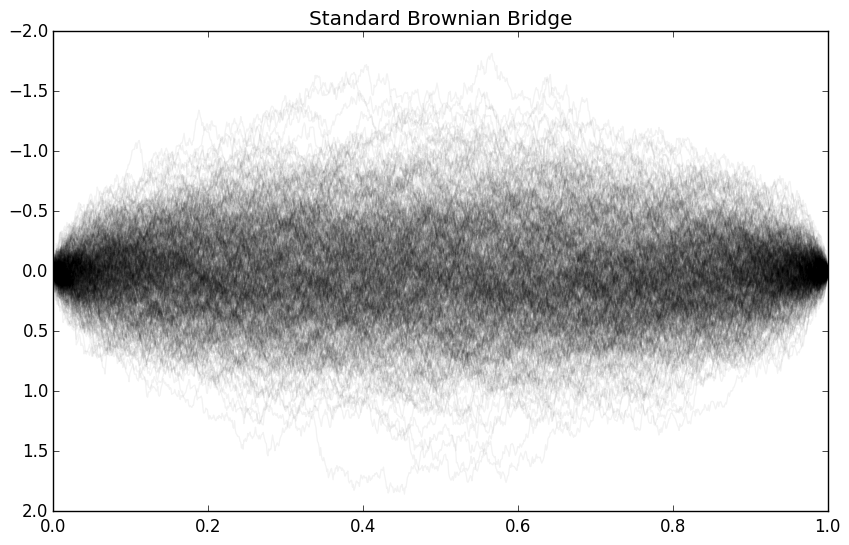

In [64]:
import PyPlot
PyPlot.pygui(false)
T = 1000
n = 500
W = cumsum(randn(T,n))/sqrt(T)
t = linspace(0,1,T)
PyPlot.figure(figsize = (10,6))
PyPlot.ylim(2,-2)
PyPlot.title("Standard Brownian Bridge")
PyPlot.plot(t, W - t*W[T,:], alpha = 0.05, color = "black");

## Gadfly.jl example: Asset prices in a DataFrame

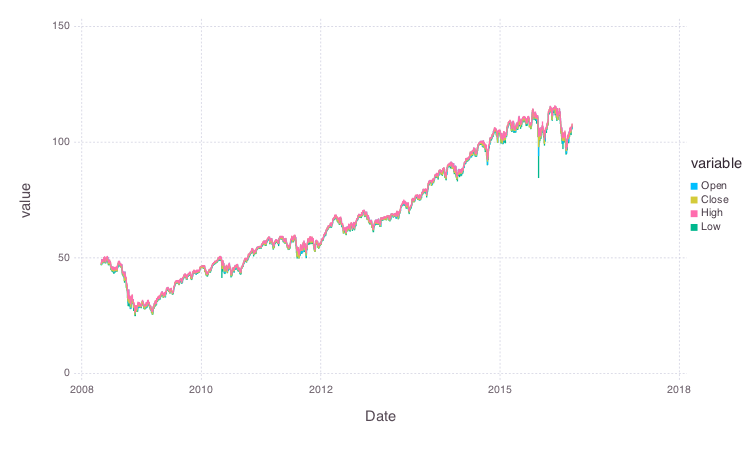

In [34]:
import Gadfly
using DataFrames
# Doesn't like NAs, but is fine with NaNs
for n in names(google), i = 1:size(google, 1)
    if isna(google[n][i])
        google[n][i] = NaN
    end
end
Gadfly.set_default_plot_size(20Gadfly.cm, 12Gadfly.cm)
Gadfly.plot(melt(google[[:Date, :Open, :Close, :High, :Low]]),
x = :Date, y = :value, Gadfly.Geom.step(), color = :variable)

## PyCall.jl
### Calling Python from Julia: Astropy
http://www.astropy.org/astropy-tutorials/FITS-images.html translated to Julia

In [65]:
using PyCall
@pyimport numpy as Numpy
@pyimport astropy.utils.data as AUD
@pyimport astropy.io.fits as Fits

### Viewing and manipulating FITS images

In [66]:
image_file = AUD.download_file(
"http://data.astropy.org/tutorials/FITS-images/HorseHead.fits", cache=true)

"/Users/andreasnoack/.astropy/cache/download/2c9202ae878ecfcb60878ceb63837f5f"

### Opening FITS files and loading the image data

In [71]:
hdu_list = Fits.open(image_file)
image_data = hdu_list[1][:data]
# Julia has one based indexing and fields are accessed as dictionary keys

893x891 Array{Int16,2}:
 7201  6642  6642  7219  7498  6939  …   9708   9778   9498   9498  10057
 6642  6363  6642  7358  7358  7219      9149   9498  10057  10616  10616
 6922  6642  6922  7638  7079  6939      9149   9778  10337  11175  10616
 7338  6918  7198  7477  7477  7058      9542  10171  10450  10590  10590
 7058  6918  6639  6918  7477  7338     10101   9612   9332   9192   9751
 6499  6918  6639  6499  6779  7058  …  10660  10031   9472   9192   9751
 6779  7198  6918  7058  6779  6779     10939  10310   9751   9472   9472
 6918  7338  7058  7268  7268  6849     10101   9891   9332   9612   9612
 6639  7058  7338  7547  7547  7128     10101   9891   9332   9332   9891
 6779  7198  7477  7408  7408  7268      9961   9891   9332   8913   9192
 7058  7198  7477  6849  6849  6988  …   9961   9891   9891   9472   9192
 6709  6988  6988  6744  7023  6604     10240   9961   9681   9681   9961
 6709  6988  6988  6744  7023  6883      9961   9961  10240  10520  10240
    ⋮         

### Viewing the image data and getting basic statistics

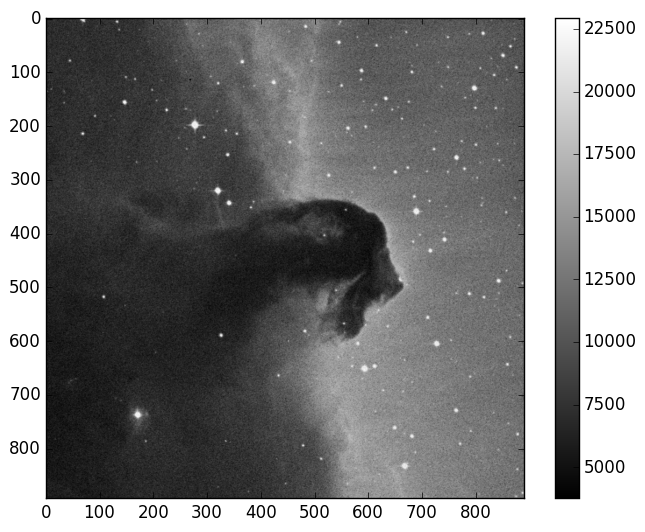

In [72]:
PyPlot.imshow(image_data, cmap="gray")
PyPlot.colorbar();

### Plotting a histogram

### Displaying the image with a logarithmic scale

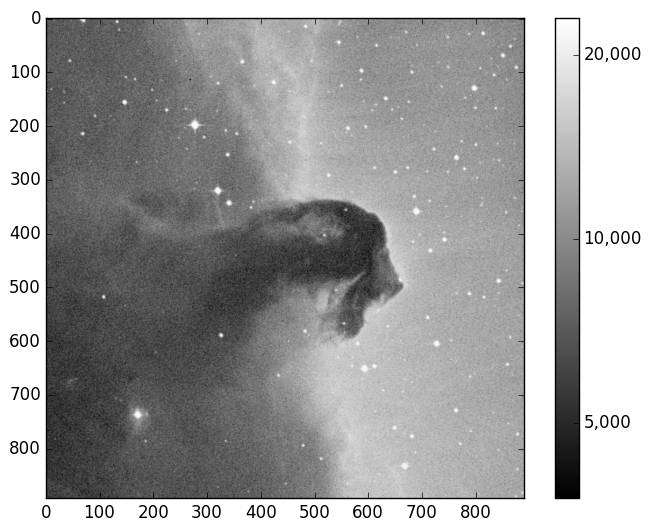

In [61]:
@pyimport matplotlib.colors as MPLCol
PyPlot.imshow(image_data, cmap = "gray", norm = MPLCol.LogNorm())
# I chose the tick marks based on the histogram above
cbar = PyPlot.colorbar(ticks=[5.e3,1.e4,2.e4])
cbar[:ax][:set_yticklabels](["5,000","10,000","20,000"]);

# Community and ecosystem

<h2 align="center">Open Source Julia Community across the World</h2>
<img src="community.png">
- Main development centers: Boston, New York, and Bangalore
- Research anchored at MIT


<img src="pkgpulse.png">

# In the pipeline

- Threading support added recently
- Debugger in alpha release and high priority
- C++ FFI